# Libraries

In [1]:
!git clone https://github.com/katyafilimoshina/tsc_msc_dl.git
!pip install pyro-ppl normflows pot

Cloning into 'tsc_msc_dl'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 93 (delta 39), reused 22 (delta 6), pack-reused 0
Receiving objects: 100% (93/93), 3.55 MiB | 6.17 MiB/s, done.
Resolving deltas: 100% (39/39), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 11.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1

In [2]:
!git clone https://github.com/svsamsonov/Practical_task
!mv Practical_task/* .
!rm -r Practical_task

Cloning into 'Practical_task'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 16 (delta 1), reused 6 (delta 0), pack-reused 0
Receiving objects: 100% (16/16), 69.74 KiB | 566.00 KiB/s, done.
Resolving deltas: 100% (1/1), done.


In [41]:
from tsc_msc_dl.distributions import Funnel, Banana
from tsc_msc_dl.samplers import ISIR, NUTS, HMC
from tsc_msc_dl.metrics import compute_metrics
from tsc_msc_dl.plots import visualize_dist_

In [2]:
import pyro
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.distributions import Normal
from torch.distributions import MultivariateNormal as MNormal
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from typing import Optional, List, Tuple, Iterable, Callable, Union
from torch.distributions import Normal, Categorical
from tqdm.notebook import tqdm, trange
from torch import optim
from torch.nn import KLDivLoss
from pyro.infer import HMC as pyro_hmc
from pyro.infer import MCMC
import normflows as nf
from torch.optim.lr_scheduler import StepLR
from distributions import (
    Distribution,
    IndependentNormal
)

# Distributions

In [42]:
torch.manual_seed(926)


class MyDistribution(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def grad_log(self, x: torch.Tensor):
        """
        Calculates gradient of log density for given points
        Expects log_prob function to be working in differentiable manner
        :param x: [n_batch, dimension]
        :return: gradients [n_batch, dimension]
        """
        grads = []
        x.requires_grad = True
        for val in x:
            val = val.reshape(1, -1)
            out = self.log_prob(val)
            grad = torch.autograd.grad(out, val)
            grads.append(grad[0].squeeze(0))
        x.requires_grad = False
        return torch.stack(grads, dim=0)


class GMM(MyDistribution):
    def __init__(self, dim, mu, sigma, rho=0.5):
        super().__init__(dim)
        cov_mat = torch.eye(dim) * sigma
        mu_mat = torch.ones((2, dim))*mu
        mu_mat[1, :] = -mu_mat[1, :]
        cov_mat = torch.tile(cov_mat.unsqueeze(0), (2, 1, 1))
        mix = D.Categorical(torch.tensor([rho, 1-rho]))
        comp = D.MultivariateNormal(
            mu_mat, cov_mat)
        self.gmm = D.MixtureSameFamily(mix, comp)

    def log_prob(self, x):
        return self.gmm.log_prob(x)

    def sample(self, n):
        return self.gmm.sample((n,))

    def plot_2d_countour(self, ax):
        """
        Visualizes contour plot of Banana distribution using log p(x)
        """
        x = np.linspace(-20, 20, 100)
        y = np.linspace(-10, 10, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])
        ax.contour(X, Y, Z.exp(),
                   levels=5,
                   alpha=1., colors='midnightblue', linewidths=1)

    def visualize_dist(self, ax, s=1000, alpha=1.0, cmap="magma"):
        """
        Visualizes Banana distribution using sampled points
        """
        # Generate points from distribution
        points = self.sample(s)
        X = points[:, 0]
        Y = points[:, 1]

        # Calculate the point density
        XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
        Z = gaussian_kde(XY)(XY)

        # Sort the points by density, so that the densest points are plotted last
        idx = Z.argsort()
        X, Y, Z = X[idx], Y[idx], Z[idx]

        ax.scatter(X, Y, c=Z, label=Z, alpha=alpha, cmap=cmap)

    def visualize_dist_nf(self, ax, s=1000, alpha=1.0, nf = None, cmap="magma"):
        """
        Visualizes GMM distribution using sampled points and NF
        """
        # Generate points from distribution
        points = self.sample(s)
        if nf:
          points = nf(points).detach()
        X = points[:, 0]
        Y = points[:, 1]

        # Calculate the point density
        XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
        Z = gaussian_kde(XY)(XY)

        # Sort the points by density, so that the densest points are plotted last
        idx = Z.argsort()
        X, Y, Z = X[idx], Y[idx], Z[idx]

        ax.scatter(X, Y, c=Z, label=Z, alpha=alpha, cmap=cmap)
        # ax.colorbar()
        # ax.show()
        # ax.close()


class Cauchy(Distribution):
    def __init__(self, **kwargs):

        super().__init__(**kwargs)
        self.loc = kwargs.get("loc")
        self.scale = kwargs.get("scale")
        self.dim = kwargs.get("dim")
        self.distr = torch.distributions.Cauchy(self.loc, self.scale)

    def log_prob(self, z, x=None):
        log_target = self.distr.log_prob(z).sum(-1)
        return log_target

    def sample(self, n=1):
        return self.distr.sample(torch.cat([torch.empty(n)], -1).shape)

    def visualize_dist(self, ax, s=1000, alpha=1.0, cmap="magma"):
        """
        Visualizes Cauchy distribution using sampled points
        """
        # Generate points from distribution
        points = self.sample(s)
        X = points[:, 0]
        Y = points[:, 1]

        # Calculate the point density
        XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
        Z = gaussian_kde(XY)(XY)

        # Sort the points by density, so that the densest points are plotted last
        idx = Z.argsort()
        X, Y, Z = X[idx], Y[idx], Z[idx]

        ax.scatter(X, Y, c=Z, label=Z, alpha=alpha, cmap=cmap)

    def visualize_dist_nf(self, ax, s=1000, alpha=1.0, nf = None, cmap="magma"):
        """
        Visualizes GMM distribution using sampled points and NF
        """
        # Generate points from distribution
        points = self.sample(s)
        if nf:
          points = nf(points).detach()
        X = points[:, 0]
        Y = points[:, 1]

        # Calculate the point density
        XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
        Z = gaussian_kde(XY)(XY)

        # Sort the points by density, so that the densest points are plotted last
        idx = Z.argsort()
        X, Y, Z = X[idx], Y[idx], Z[idx]

        ax.scatter(X, Y, c=Z, label=Z, alpha=alpha, cmap=cmap)
        # ax.colorbar()
        # ax.show()
        # ax.close()

# HMC

In [5]:
def HMC(
    start,
    target,
    n_samples: int,
    burn_in: int,
    *,
    step_size: float,
    num_leapfrog_steps: float = 1,
    verbose: bool = False,
) -> torch.FloatTensor:
    """
    Hamiltonian Monte Carlo

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates
        for each iteration
    """

    x = start.clone().detach()
    x.requires_grad_(False)

    def energy(z):
        z = z["points"]
        return -target.log_prob(z).sum()

    kernel = pyro_hmc(
        potential_fn=energy,
        step_size=step_size,
        num_steps=num_leapfrog_steps,
        full_mass=False,
    )

    init_params = {"points": x}
    mcmc_true = MCMC(
        kernel=kernel,
        num_samples=n_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
        disable_progbar= not verbose
    )
    mcmc_true.run()
    q_true = mcmc_true.get_samples(group_by_chain=True)["points"]
    samples_true = q_true.view(-1, *start.shape)

    return samples_true

# Metrics
Due to some errors specific for this case, we decided to re-write metrics code here.

In [28]:
import jax
from flax import struct
from jax import numpy as jnp
from scipy.stats import gaussian_kde
import ot
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import trange



def compute_metrics(
    xs_true,
    xs_pred,
    name=None,
    n_samples=1000,
    scale=1.0,
    trunc_chain_len=None,
    ess_rar=1,
):
    if name is not None:
        print(f"===={name}====")

    metrics = dict()
    key = jax.random.PRNGKey(0)
    n_steps = 50
    # n_samples = 100

    ess = ESS(
        acl_spectrum(
            xs_pred[::ess_rar] - xs_pred[::ess_rar].mean(0)[None, ...],
        ),
    ).mean()
    metrics["ess"] = ess
    print(f"ESS: {ess:.3f}")

    xs_pred = xs_pred[-trunc_chain_len:]

    try:
        tracker = average_total_variation(
            key,
            xs_true,
            xs_pred,
            n_steps=n_steps,
            n_samples=n_samples,
        )

        metrics["tv_mean"] = tracker.mean()
        metrics["tv_conf_sigma"] = tracker.std_of_mean()

        mean = tracker.mean()
        std = tracker.std()
        print(f"TV distance. Mean: {mean:.3f}, Std: {std:.3f}.")
    except:
        print(f"TV distance failed =(")

    metrics["emd"] = 0
    #Cost_matr_isir = ot.dist(x1 = isir_res[j][i], x2=gt_samples[i], metric='sqeuclidean', p=2, w=None)
    for b in range(xs_pred.shape[1]):
        M = ot.dist(xs_true / scale, xs_pred[:, b,:] / scale)
        emd = ot.lp.emd2([], [], M, numItermax = 1e6)
        metrics["emd"] += emd / xs_pred.shape[1]

    print(f"EMD: {emd:.3f}")


    return metrics


def plot_metrics(metrics_list):
  """
  Plots metrics (ESS, ESTV, EMD) values history from training
  """
  num_of_iters = [d['num_of_iter'] for d in metrics_list]
  ess_values = [d['ess'] for d in metrics_list]
  emd_values = [d['emd'] for d in metrics_list]
  tv_mean_values = [d['tv_mean'] for d in metrics_list]
  tv_std_values = [d['tv_conf_sigma'] for d in metrics_list]

  ess_values = np.nan_to_num(ess_values, nan=0.0)
  emd_values = np.nan_to_num(emd_values, nan=0.0)
  tv_mean_values = np.nan_to_num(tv_mean_values, nan=0.0)
  tv_std_values = np.nan_to_num(tv_std_values, nan=0.0)

  fig, axs = plt.subplots(2, 2, figsize=(12, 8))

  # Plot ESS
  axs[0, 0].plot(num_of_iters, ess_values, marker='o')
  axs[0, 0].set_title('ESS vs Num of training iterations')
  axs[0, 0].set_xlabel('Number of training iterations')
  axs[0, 0].set_ylabel('ESS')

  # Plot EMD
  axs[0, 1].plot(num_of_iters, emd_values, marker='o')
  axs[0, 1].set_title('EMD vs Num of training iterations')
  axs[0, 1].set_xlabel('Number of training iterations')
  axs[0, 1].set_ylabel('EMD')

  # Plot TV Mean
  axs[1, 0].plot(num_of_iters, tv_mean_values, marker='o')
  axs[1, 0].set_title('TV Mean vs Num of training iterations')
  axs[1, 0].set_xlabel('Number of training iterations')
  axs[1, 0].set_ylabel('TV Mean')

  # Plot TV Std
  axs[1, 1].plot(num_of_iters, tv_std_values, marker='o')
  axs[1, 1].set_title('TV Std vs Num of training iterations')
  axs[1, 1].set_xlabel('Number of training iterations')
  axs[1, 1].set_ylabel('TV Std')

  plt.tight_layout()
  plt.show()





def ESS(A):
    # ess = ESS(acl_spectrum((trunc_sample - trunc_sample.mean(0)[None, ...]))).mean()
    A = A * (A > 0.05)
    ess = 1.0 / (1.0 + 2 * np.sum(A[1:, ...], axis=0))
    return ess


def autocovariance(X, tau=0):
    # dT, dX = np.shape(X)
    dT = X.shape[0]
    s = 0.0
    dN = 1
    if tau > 0:
        x1 = X[:-tau, ...]
    else:
        x1 = X
    x2 = X[tau:, ...]
    s = np.sum(x1 * x2, axis=0) / dN

    return s / (dT - tau)



def acl_spectrum(X, n=150, scale=None):
    scale = (
        np.array(scale)
        if scale is not None
        else np.sqrt(autocovariance(X, tau=0))
    )
    return np.stack(
        [
            autocovariance(X / (scale[None, ...] + 1e-7), tau=t)
            for t in range(n - 1)
        ],
        axis=0,
    )


class MeanTracker:
    def __init__(self):
        self.values = []

    def update(self, value: float) -> None:
        self.values.append(value)

    def __len__(self):
        return len(self.values)

    def mean(self) -> float:
        return jnp.mean(jnp.array(self.values))

    def std(self) -> float:
        return jnp.std(jnp.array(self.values), ddof=1)

    def std_of_mean(self) -> float:
        return jnp.std(jnp.array(self.values)) / jnp.sqrt(len(self))

    def last(self) -> float:
        return self.values[-1]


@struct.dataclass
class Projector:
    x0: jnp.ndarray
    v: jnp.ndarray

    def project(self, xs: jnp.ndarray) -> jnp.ndarray:
        return (xs - self.x0[None]) @ self.v


def create_random_projection(key: jnp.ndarray, xs: jnp.ndarray) -> Projector:
    x0 = jnp.mean(xs, 0)
    v = jax.random.normal(key, [len(x0)])
    v = v / jnp.linalg.norm(v)

    return Projector(x0, v)


def total_variation_1d(xs_true, xs_pred, n_samples):
    true_density = gaussian_kde(xs_true)
    pred_density = gaussian_kde(xs_pred)

    x_min = min(xs_true.min(), xs_pred.min())
    x_max = max(xs_true.max(), xs_pred.max())

    points = np.linspace(x_min, x_max, n_samples)

    return (
        0.5
        * np.abs(true_density(points) - pred_density(points)).mean()
        * (x_max - x_min)
    )


def total_variation(
    key: jnp.ndarray,
    xs_true: jnp.ndarray,
    xs_pred: jnp.ndarray,
    n_samples: int,
):
    proj = create_random_projection(key, xs_true)
    return total_variation_1d(
        proj.project(xs_true),
        proj.project(xs_pred),
        n_samples,
    )


def average_total_variation(
    key: jnp.ndarray,
    true: jnp.ndarray,
    other: jnp.ndarray,
    n_samples: int,
    n_steps: int,
) -> MeanTracker:
    tracker = MeanTracker()
    keys = jax.random.split(key, n_steps)

    for b in range(other.shape[1]):
        for i in trange(n_steps, leave=False):
            tracker.update(total_variation(keys[i], true, other[:, b], n_samples))
    return tracker

# Training parameters

  0%|          | 0/500 [00:00<?, ?it/s]

Sample: 100%|██████████| 10/10 [00:00, 224.59it/s, step size=1.60e+00, acc. prob=0.391]


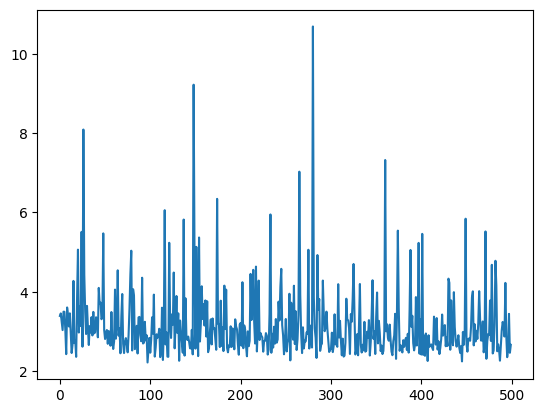

Sample: 100%|██████████| 10000/10000 [00:20, 499.69it/s, step size=1.60e+00, acc. prob=0.348]


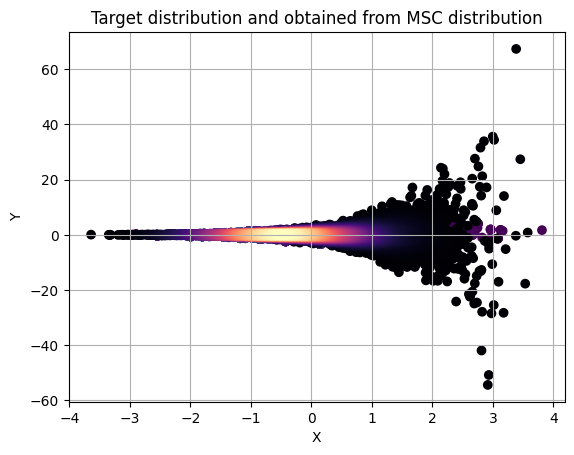

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.095, Std: 0.002. 
ESS: 0.151 
EMD: 2.494


In [50]:
dim = 2
target = Funnel(num_dims=dim)

loc = nn.Parameter(torch.ones(dim))
scale = nn.Parameter(torch.ones(dim))

proposal = GMM(dim=dim, sigma=scale, mu=loc)

N_CHAINS = torch.tensor(1)
N_SAMPLES = 10
BURN_IN = 0
device="cpu"


n_iter = 500
loss_arr = []

optimizer = optim.Adam(lr=1e-1, params=(loc, scale))
scheduler = StepLR(optimizer, 1, gamma=1-1e-2)

for i in tqdm(range(n_iter)):
    optimizer.zero_grad()
    proposal = GMM(dim=dim, sigma=scale, mu=loc)

    chains = HMC(
                  proposal.sample(N_CHAINS),
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size = 0.05,
                  num_leapfrog_steps = 20,
                  verbose = False,
                )
    #log_p = target.log_prob(chains)
    log_q = proposal.log_prob(chains)

    loss = (-1 * log_q).sum()
    loss.backward()

    optimizer.step()

    scheduler.step()

    loss_arr.append(loss.detach().item()/log_q.shape[0])

plt.plot(loss_arr)
plt.show()


# Plot
N_SAMPLES = 10000
z = HMC(
        proposal.sample(N_CHAINS),
        target,
        N_SAMPLES,
        BURN_IN,
        step_size = 0.05,
        num_leapfrog_steps = 20,
        verbose = False)

numpy_array = z.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from MSC distribution')
ax.grid(True)
visualize_dist_(numpy_array, ax)
target.visualize_dist(ax=ax, s=N_SAMPLES)
plt.show()


# Metrics
N_SAMPLES_METRICS = 1000

msc_points = z
true_points = target.sample(N_SAMPLES)

metrics = compute_metrics(
                      true_points.numpy(), # True samples [num of samples, dim]
                      msc_points.numpy(), # Generated samples [num_of_samples, num of chains, dim]
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

Sample: 100%|██████████| 10000/10000 [00:21, 474.23it/s, step size=3.20e+00, acc. prob=0.031]


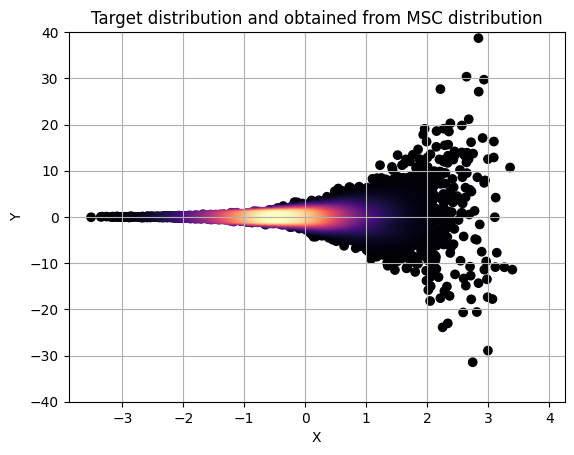

In [51]:
# Plot
N_SAMPLES = 10000
z = HMC(
        proposal.sample(N_CHAINS),
        target,
        N_SAMPLES,
        BURN_IN,
        step_size = 0.05,
        num_leapfrog_steps = 20,
        verbose = False)

numpy_array = z.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from MSC distribution')
ax.grid(True)
ax.set_ylim([-40, 40])
visualize_dist_(numpy_array, ax)
target.visualize_dist(ax=ax, s=N_SAMPLES)
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

Sample: 100%|██████████| 15/15 [00:00, 374.11it/s, step size=7.17e-01, acc. prob=0.678]


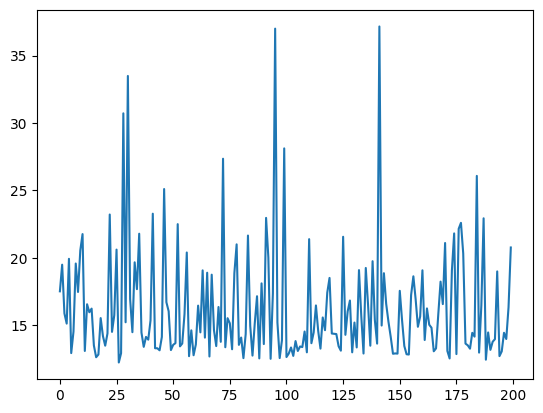

Sample:  40%|████      | 4/10 [15:52, 238.23s/it, step size=1.60e+00, acc. prob=0.077]


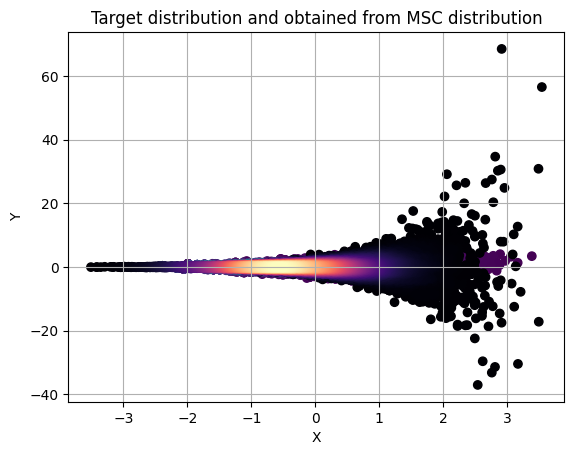

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.121, Std: 0.003. 
ESS: 0.026 
EMD: 44.604


In [58]:
dim = 10
target = Funnel(num_dims=dim)

loc = nn.Parameter(torch.ones(dim))
scale = nn.Parameter(torch.ones(dim))

proposal = GMM(dim=dim, sigma=scale, mu=loc)

N_CHAINS = torch.tensor(1)
N_SAMPLES = 10
BURN_IN = 5
device="cpu"


n_iter = 200
loss_arr = []

optimizer = optim.Adam(lr=1e-1, params=(loc, scale))
scheduler = StepLR(optimizer, 10, gamma=5e-1)

for i in tqdm(range(n_iter)):
    optimizer.zero_grad()
    proposal = GMM(dim=dim, sigma=scale, mu=loc)

    chains = HMC(
                  proposal.sample(N_CHAINS),
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size = 0.05,
                  num_leapfrog_steps = 20,
                  verbose = False,
                )
    #log_p = target.log_prob(chains)
    log_q = proposal.log_prob(chains)

    loss = (-1 * log_q).sum()
    loss.backward()

    optimizer.step()

    scheduler.step()

    loss_arr.append(loss.detach().item()/log_q.shape[0])

plt.plot(loss_arr)
plt.show()


# Plot
N_SAMPLES = 10000
z = HMC(
        proposal.sample(N_CHAINS),
        target,
        N_SAMPLES,
        BURN_IN,
        step_size = 0.05,
        num_leapfrog_steps = 20,
        verbose = False)

numpy_array = z.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from MSC distribution')
ax.grid(True)
visualize_dist_(numpy_array, ax)
target.visualize_dist(ax=ax, s=N_SAMPLES)
plt.show()

# Sanity check
ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('MSC only')
ax.grid(True)
visualize_dist_(numpy_array, ax)
plt.show()


# Metrics
N_SAMPLES_METRICS = 1000

msc_points = z
true_points = target.sample(N_SAMPLES)

metrics = compute_metrics(
                      true_points.numpy(), # True samples [num of samples, dim]
                      msc_points.numpy(), # Generated samples [num_of_samples, num of chains, dim]
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/200 [00:00<?, ?it/s]

Sample: 100%|██████████| 15/15 [00:00, 141.32it/s, step size=1.48e-01, acc. prob=0.938]


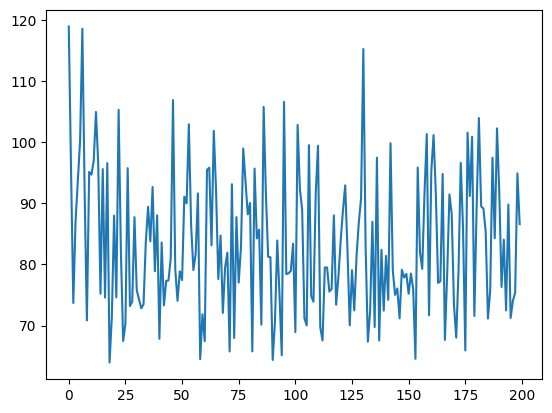

Sample: 100%|██████████| 10005/10005 [00:54, 183.05it/s, step size=2.47e-01, acc. prob=0.841]


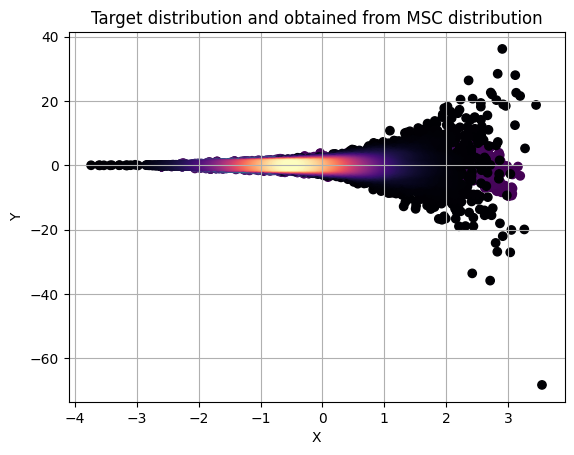

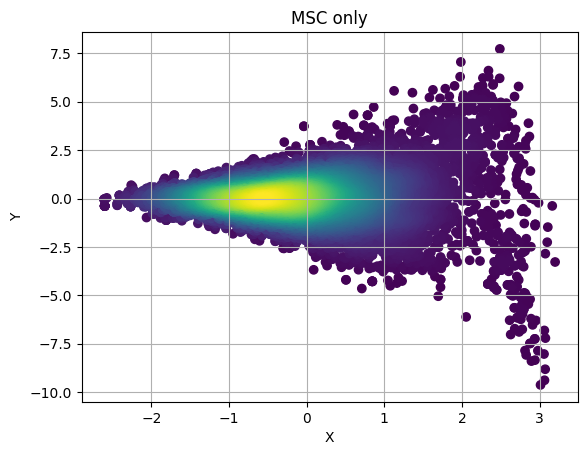

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.138, Std: 0.002. 
ESS: 0.045 
EMD: 321.339


In [61]:
dim = 50
target = Funnel(num_dims=dim)

loc = nn.Parameter(torch.ones(dim))
scale = nn.Parameter(torch.ones(dim))

proposal = GMM(dim=dim, sigma=scale, mu=loc)

N_CHAINS = torch.tensor(1)
N_SAMPLES = 10
BURN_IN = 5
device="cpu"


n_iter = 200
loss_arr = []

optimizer = optim.Adam(lr=1e-1, params=(loc, scale))
scheduler = StepLR(optimizer, 10, gamma=5e-1)

for i in tqdm(range(n_iter)):
    optimizer.zero_grad()
    proposal = GMM(dim=dim, sigma=scale, mu=loc)

    chains = HMC(
                  proposal.sample(N_CHAINS),
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size = 0.05,
                  num_leapfrog_steps = 20,
                  verbose = False,
                )
    #log_p = target.log_prob(chains)
    log_q = proposal.log_prob(chains)

    loss = (-1 * log_q).sum()
    loss.backward()

    optimizer.step()

    scheduler.step()

    loss_arr.append(loss.detach().item()/log_q.shape[0])

plt.plot(loss_arr)
plt.show()


# Plot
N_SAMPLES = 10000
z = HMC(
        proposal.sample(N_CHAINS),
        target,
        N_SAMPLES,
        BURN_IN,
        step_size = 0.05,
        num_leapfrog_steps = 20,
        verbose = False)

numpy_array = z.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from MSC distribution')
ax.grid(True)
ax.set_ylim([-40, 40])
visualize_dist_(numpy_array, ax)
target.visualize_dist(ax=ax, s=N_SAMPLES)
plt.show()

# Sanity check
ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('MSC only')
ax.grid(True)
visualize_dist_(numpy_array, ax)
plt.show()


# Metrics
N_SAMPLES_METRICS = 1000

msc_points = z
true_points = target.sample(N_SAMPLES)

metrics = compute_metrics(
                      true_points.numpy(), # True samples [num of samples, dim]
                      msc_points.numpy(), # Generated samples [num_of_samples, num of chains, dim]
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )

  0%|          | 0/200 [00:00<?, ?it/s]

Sample: 100%|██████████| 15/15 [00:00, 104.54it/s, step size=1.48e-01, acc. prob=0.850]


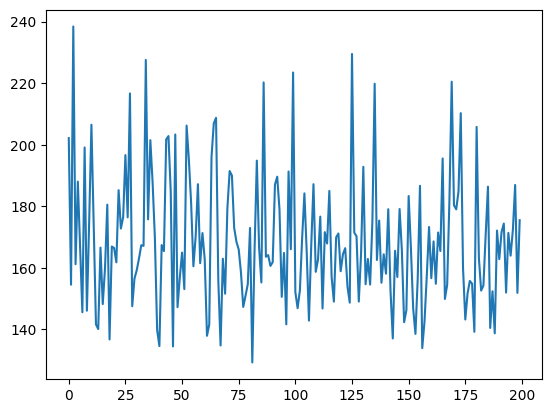

Sample: 100%|██████████| 10005/10005 [01:16, 130.52it/s, step size=1.48e-01, acc. prob=0.924]


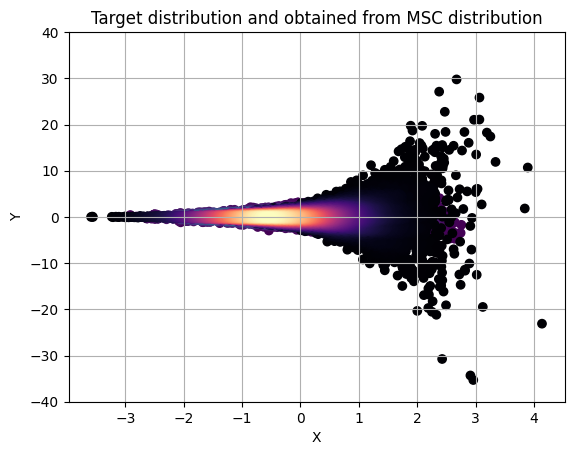

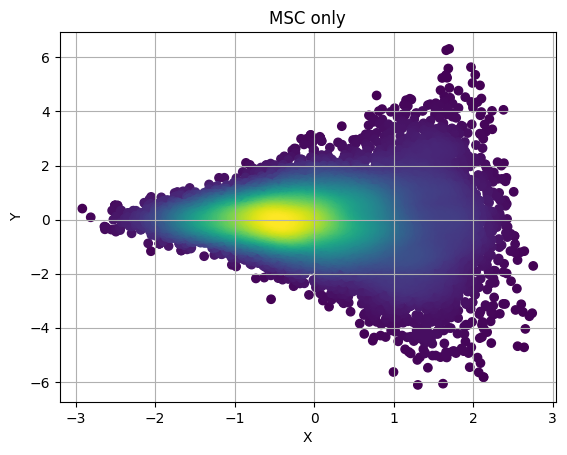

  0%|          | 0/50 [00:00<?, ?it/s]

====Metrics====
TV distance. Mean: 0.113, Std: 0.002. 
ESS: 0.058 
EMD: 701.023


In [64]:
dim = 100
target = Funnel(num_dims=dim)

loc = nn.Parameter(torch.ones(dim))
scale = nn.Parameter(torch.ones(dim))

proposal = GMM(dim=dim, sigma=scale, mu=loc)

N_CHAINS = torch.tensor(1)
N_SAMPLES = 10
BURN_IN = 5
device="cpu"


n_iter = 200
loss_arr = []

optimizer = optim.Adam(lr=1e-1, params=(loc, scale))
scheduler = StepLR(optimizer, 10, gamma=5e-1)

for i in tqdm(range(n_iter)):
    optimizer.zero_grad()
    proposal = GMM(dim=dim, sigma=scale, mu=loc)

    chains = HMC(
                  proposal.sample(N_CHAINS),
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size = 0.05,
                  num_leapfrog_steps = 20,
                  verbose = False,
                )
    #log_p = target.log_prob(chains)
    log_q = proposal.log_prob(chains)

    loss = (-1 * log_q).sum()
    loss.backward()

    optimizer.step()

    scheduler.step()

    loss_arr.append(loss.detach().item()/log_q.shape[0])

plt.plot(loss_arr)
plt.show()


# Plot
N_SAMPLES = 10000
z = HMC(
        proposal.sample(N_CHAINS),
        target,
        N_SAMPLES,
        BURN_IN,
        step_size = 0.05,
        num_leapfrog_steps = 20,
        verbose = False)

numpy_array = z.squeeze().detach().numpy()

ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Target distribution and obtained from MSC distribution')
ax.grid(True)
ax.set_ylim([-40, 40])
visualize_dist_(numpy_array, ax)
target.visualize_dist(ax=ax, s=N_SAMPLES)
plt.show()

# Sanity check
ax = plt.subplot()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('MSC only')
ax.grid(True)
visualize_dist_(numpy_array, ax)
plt.show()


# Metrics
N_SAMPLES_METRICS = 1000

msc_points = z
true_points = target.sample(N_SAMPLES)

metrics = compute_metrics(
                      true_points.numpy(), # True samples [num of samples, dim]
                      msc_points.numpy(), # Generated samples [num_of_samples, num of chains, dim]
                      name=f"Metrics",
                      n_samples=N_SAMPLES_METRICS,
                      trunc_chain_len=N_SAMPLES_METRICS,
                      ess_rar=1,
      )